# Environment

Now we have a trainable discriminator - it's time to build the environment

In [28]:
## Imports and data loading

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import metrics

import gym

from musicrl.midi2vec import MidiVectorMapper
from musicrl.render import *
from musicrl.random_generator import generate_random_midi, resemble_midi
from musicrl.data import RandomMidiDataGenerator
from musicrl import mel_lstm

import pretty_midi
from glob import glob


REAL = 1
GEN = 0

na = None # new axis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
filepaths = list(glob('maestro-v2.0.0/2008/**.midi'))
real_midis = [pretty_midi.PrettyMIDI(i) for i in filepaths]
mapper = MidiVectorMapper(real_midis)

In [3]:
mapper = MidiVectorMapper(real_midis)
real_seq = mapper.midi2vec(real_midis[1])
real_seq.shape

(2939, 9)

In [4]:
notes = []
for event in real_seq:
    if isinstance(mapper.action2note(event), pretty_midi.Note):
        notes.append(event)

In [5]:
mapper.dims

9

In [109]:
# import gym
import pretty_midi


class MelEnvironment(gym.Env):
    """Environment to grain generating midi data in a self defined
    vector space. The midi vector representation is defined via the
    mapper object.
    The waveform for the single instrument is then preprocessed for the
    discriminator, and at each time step, the discriminators final prediction
    serves as reward.
    The preprocessed waveform, i.e. the mel spectrogram, also serves as
    observation. The number of time frames that are used for the observation
    are defined by the constant `self.N_TIMESTEPS`.
    One session is understood as one song.
    
    Gets:
        discriminator: keras.Model: np.array(preprocessed) -> np.array(#time_steps, 1)
        preprocess: function: np.array(#actions): waveform -> np.array(preprocessed) : spectrogram
        mapper: musicrl.midi2vec.MidiVectorMapper
        N_TIMESTEPS: int: number of timesteps used to generate the observation
        MAX_NUM_ACTIONS: int: number of actions after which to end a trajectory
    """
    def __init__(self, discriminator, preprocess_wav, mapper, N_TIMESTEPS=100, MAX_NUM_ACTIONS=10000):
        super().__init__()
        # N_TIMESTEPS is used to define the observation:
        # This many timeframes of the spectrogram are fed
        # back to the generator
        self.N_TIMESTEPS = N_TIMESTEPS
        self.MAX_NUM_ACTIONS = MAX_NUM_ACTIONS
        # Define action and observation space
        # They must be gym.spaces objects
        self.action_space = gym.spaces.Box(0, np.inf, shape=(mapper.dims,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf,
                                           shape=(self.N_TIMESTEPS, 128), dtype=np.float32)
        self.discriminator = discriminator
        self.preprocess_wav = preprocess_wav
        self.mapper = mapper
        self.fr = 44100
        self.rewards = []
        self.current_seq = []
        self.current_midi = pretty_midi.PrettyMIDI(resolution=384, initial_tempo=300)
        self.current_midi.instruments.append(pretty_midi.Instrument(program=0))
        self.current_observation = np.zeros((self.N_TIMESTEPS, 128))
     
    def _update_wav(self, action):
        self.current_seq.append(action)
        event = mapper.action2note(action)
        if isinstance(event, pretty_midi.Note):
            if len(self.current_midi.instruments[0].notes) == 1:
                # It is the first note, so we synthesize
                self.current_midi.instruments[0].notes.append(event)
                self.current_midi.instruments[0].synthesize(self.fr)
            else:
                self.current_midi.instruments[0].append_and_synthesize(event)
            return True
        
        
    def step(self, action):
        print("lets do a step")
        print(action)
        print("ok")
        self._update_wav(action)
        preprocessed = self.preprocess_wav(self.current_wav, self.fr)[na]
        prediction = self.discriminator.predict_on_batch(preprocessed)
        observation = np.zeros((self.N_TIMESTEPS, 128))
        observation[-min(self.N_TIMESTEPS, len(preprocessed[0])):] = preprocessed[0, -self.N_TIMESTEPS:]
        self.current_observation = observation
        self.current_prediction = prediction
        reward = prediction[0, -1, 0]
        self.rewards.append(reward)
        # TODO: add a end token to mapper (issue #1)
        done = len(self.current_seq) >= self.MAX_NUM_ACTIONS
        return observation, reward, done, None

    def reset(self):
        self.current_seq = []
        self.current_midi = pretty_midi.PrettyMIDI(resolution=384, initial_tempo=300)
        self.current_midi.instruments.append(pretty_midi.Instrument(program=0))
        self.current_observation = np.zeros((self.N_TIMESTEPS, 128))
        self.rewards = []
        return self.current_observation
    
    @property
    def current_wav(self):
        return self.current_midi.instruments[0].synthesized

    def render(self, mode='human'):
        plot_spectro(self.current_observation.T, "Current observation")
    
    def close (self):
        pass
        
        
discriminator = load_model("models/mel_lstm.h5")

env = MelEnvironment(discriminator, mel_lstm.preprocess_wav, mapper, 1000)

    
    
    
from musicrl.agent import *
from musicrl.models import *
from tqdm import *

'''
env.reset()
for _ in range(1000):
    print("ok")
    env.render()
    action= agent.get_action([])
    print(action)
    env.step(action)
env.close()
'''


agent = DPPGAgent(env)


# First, gather experience
config = {
    "nb_episodes" : 10,
    "batch_size" : 32
}

print(range(config["nb_episodes"]))

tqdm_e = tqdm(range(config["nb_episodes"]), desc='Score', leave=True, unit=" episodes")
for e in tqdm_e:

    # Reset episode
    time, cumul_reward, done = 0, 0, False
    old_state = env.reset()
    actions, states, rewards = [], [], []

    while not done:
        env.render()
        # Actor picks an action (following the deterministic policy)
        action = agent.policy_action(old_state)
        # Clip continuous values to be valid w.r.t. environment
        #a = np.clip(a+noise.generate(time), -self.act_range, self.act_range)
        # Retrieve new state, reward, and whether the state is terminal
        
        print("we make a step")
        new_state, r, done, _ = env.step(action)
        
        # Add outputs to memory buffer
        agent.memorize(old_state, a, r, done, new_state)
        # Sample experience from buffer
        states, actions, rewards, dones, new_states, _ = agent.sample_batch(config["batch_size"])
        # Predict target q-values using target networks
        
        print("new states:")
        print(new_states)
        print(new_states.shape)
        q_values = agent.critic_target.predict(new_states, agent.actor_target.predict(new_states))        
        # Compute critic target
        
        
        print(q_values)
        print(rewards)
        print(dones)
        critic_target = agent.bellman(rewards, q_values, dones)
        # Train both networks on sampled batch, update target networks
        agent.update_models(states, actions, critic_target)
        # Update current state
        old_state = new_state
        cumul_reward += r
        time += 1

    # Gather stats every episode for plotting
    if(args.gather_stats):
        mean, stdev = gather_stats(self, env)
        results.append([e, mean, stdev])

    # Export results for Tensorboard
    score = tfSummary('score', cumul_reward)
    summary_writer.add_summary(score, global_step=e)
    summary_writer.flush()
    # Display score
    tqdm_e.set_description("Score: " + str(cumul_reward))
    tqdm_e.refresh()

            

/Users/alessandroschneider/anaconda3/envs/midi-rl/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


AttributeError: 'Critic' object has no attribute 'model'

/Users/alessandroschneider/anaconda3/envs/midi-rl/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


' \nfor i, action in enumerate(notes):\n    env.step(action)\n    if i % 500 == 0:\n        env.render()\n        plt.show()\n    if i > 500: break\n'

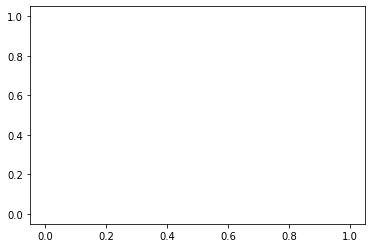

[autoreload of musicrl.agent failed: Traceback (most recent call last):
  File "/Users/alessandroschneider/anaconda3/envs/midi-rl/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/alessandroschneider/anaconda3/envs/midi-rl/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/alessandroschneider/anaconda3/envs/midi-rl/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/alessandroschneider/anaconda3/envs/midi-rl/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code


NameError: name 'MemoryBuffer' is not defined

In [ ]:
plt.plot(env.rewards)
plt.show()